# Validation: Testing effect of leaving out CMs 
This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* tests the effect of leaving out CMs on overall CM effectiveness

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import scipy
import copy

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor
import sensitivityplotlib as spl

sns.set_style("ticks")
%matplotlib inline

In [29]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("../final_data/data_final.csv")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Healthcare Infection Control
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


AttributeError: 'PreprocessedData' object has no attribute 'shape'

In [6]:
def leavout_cm(data, cm_leavouts, i):
    data_cm_leavout = copy.deepcopy(data)
    print('CM left out: ' + cm_leavouts[i])
    if cm_leavouts[i]=='None':
        pass
    else:
        data_cm_leavout.ActiveCMs = np.delete(data_cm_leavout.ActiveCMs, i, 1)
        data_cm_leavout.CMs = np.delete(data_cm_leavout.CMs, i)
    return data_cm_leavout

### Build and run models
skip if you already have traces

In [30]:
model_types = ['combined', 'active', 'death']
cm_leavouts = copy.deepcopy(data.CMs)
cm_leavouts.append('None')

['Mask Wearing', 'Symptomatic Testing', 'Gatherings <1000', 'Gatherings <100', 'Gatherings <10', 'Some Businesses Suspended', 'Most Businesses Suspended', 'School Closure', 'Stay Home Order']


In [31]:
for model_type in model_types:
    for i in range(len(cm_leavouts)):
        data_cm_leavout = leavout_cm(data, cm_leavouts, i)
        print('Model: ' + str(model_type))
        if model_type=='combined':         
            with cm_effect.models.CMCombined_Final(data_cm_leavout) as model:
                    model.build_model()  
        if model_type=='active':
            with cm_effect.models.CMActive_Final(data_cm_leavout) as model:
                    model.build_model()  
        if model_type=='death':
            with cm_effect.models.CMDeath_Final(data_cm_leavout) as model:
                    model.build_model()                      
                    
        model.run(1000, chains=8, cores=8)
        filename = 'out_final/cm_leavout_' + model_type + '_' + str(i) + '.txt'
        cm_trace = model.trace["CMReduction"]
        np.savetxt(filename, cm_trace)

CM left out: Mask Wearing
Model: combined
CM left out: Symptomatic Testing
Model: combined
CM left out: Gatherings <1000
Model: combined
CM left out: Gatherings <100
Model: combined
CM left out: Gatherings <10
Model: combined
CM left out: Some Businesses Suspended
Model: combined
CM left out: Most Businesses Suspended
Model: combined
CM left out: School Closure
Model: combined
CM left out: Stay Home Order
Model: combined
CM left out: None
Model: combined
CM left out: Mask Wearing
Model: active
CM left out: Symptomatic Testing
Model: active
CM left out: Gatherings <1000
Model: active
CM left out: Gatherings <100
Model: active
CM left out: Gatherings <10
Model: active
CM left out: Some Businesses Suspended
Model: active
CM left out: Most Businesses Suspended
Model: active


KeyboardInterrupt: 

## Plot cm effectiveness

In [22]:
figsize=(8, 5)
colors = sns.color_palette("hls",11)
colors[-1] = [0,0,0]
y_offset = 0.08
y_scale = 1.5
fontsize=10
bbox_to_anchor = (1.1, 1.07)
cm_labels = data.CMs
legend_title='CM Left Out'
legend_labels = cm_leavouts

##### plot combined model

['Mask Wearing', 'Symptomatic Testing', 'Gatherings <1000', 'Gatherings <100', 'Gatherings <10', 'Some Businesses Suspended', 'Most Businesses Suspended', 'School Closure', 'Stay Home Order']
['Mask Wearing', 'Symptomatic Testing', 'Gatherings <1000', 'Gatherings <100', 'Gatherings <10', 'Some Businesses Suspended', 'Most Businesses Suspended', 'School Closure', 'Stay Home Order', 'None']
(8000, 9)
10


ValueError: x and y must have same first dimension, but have shapes (10,) and (9,)

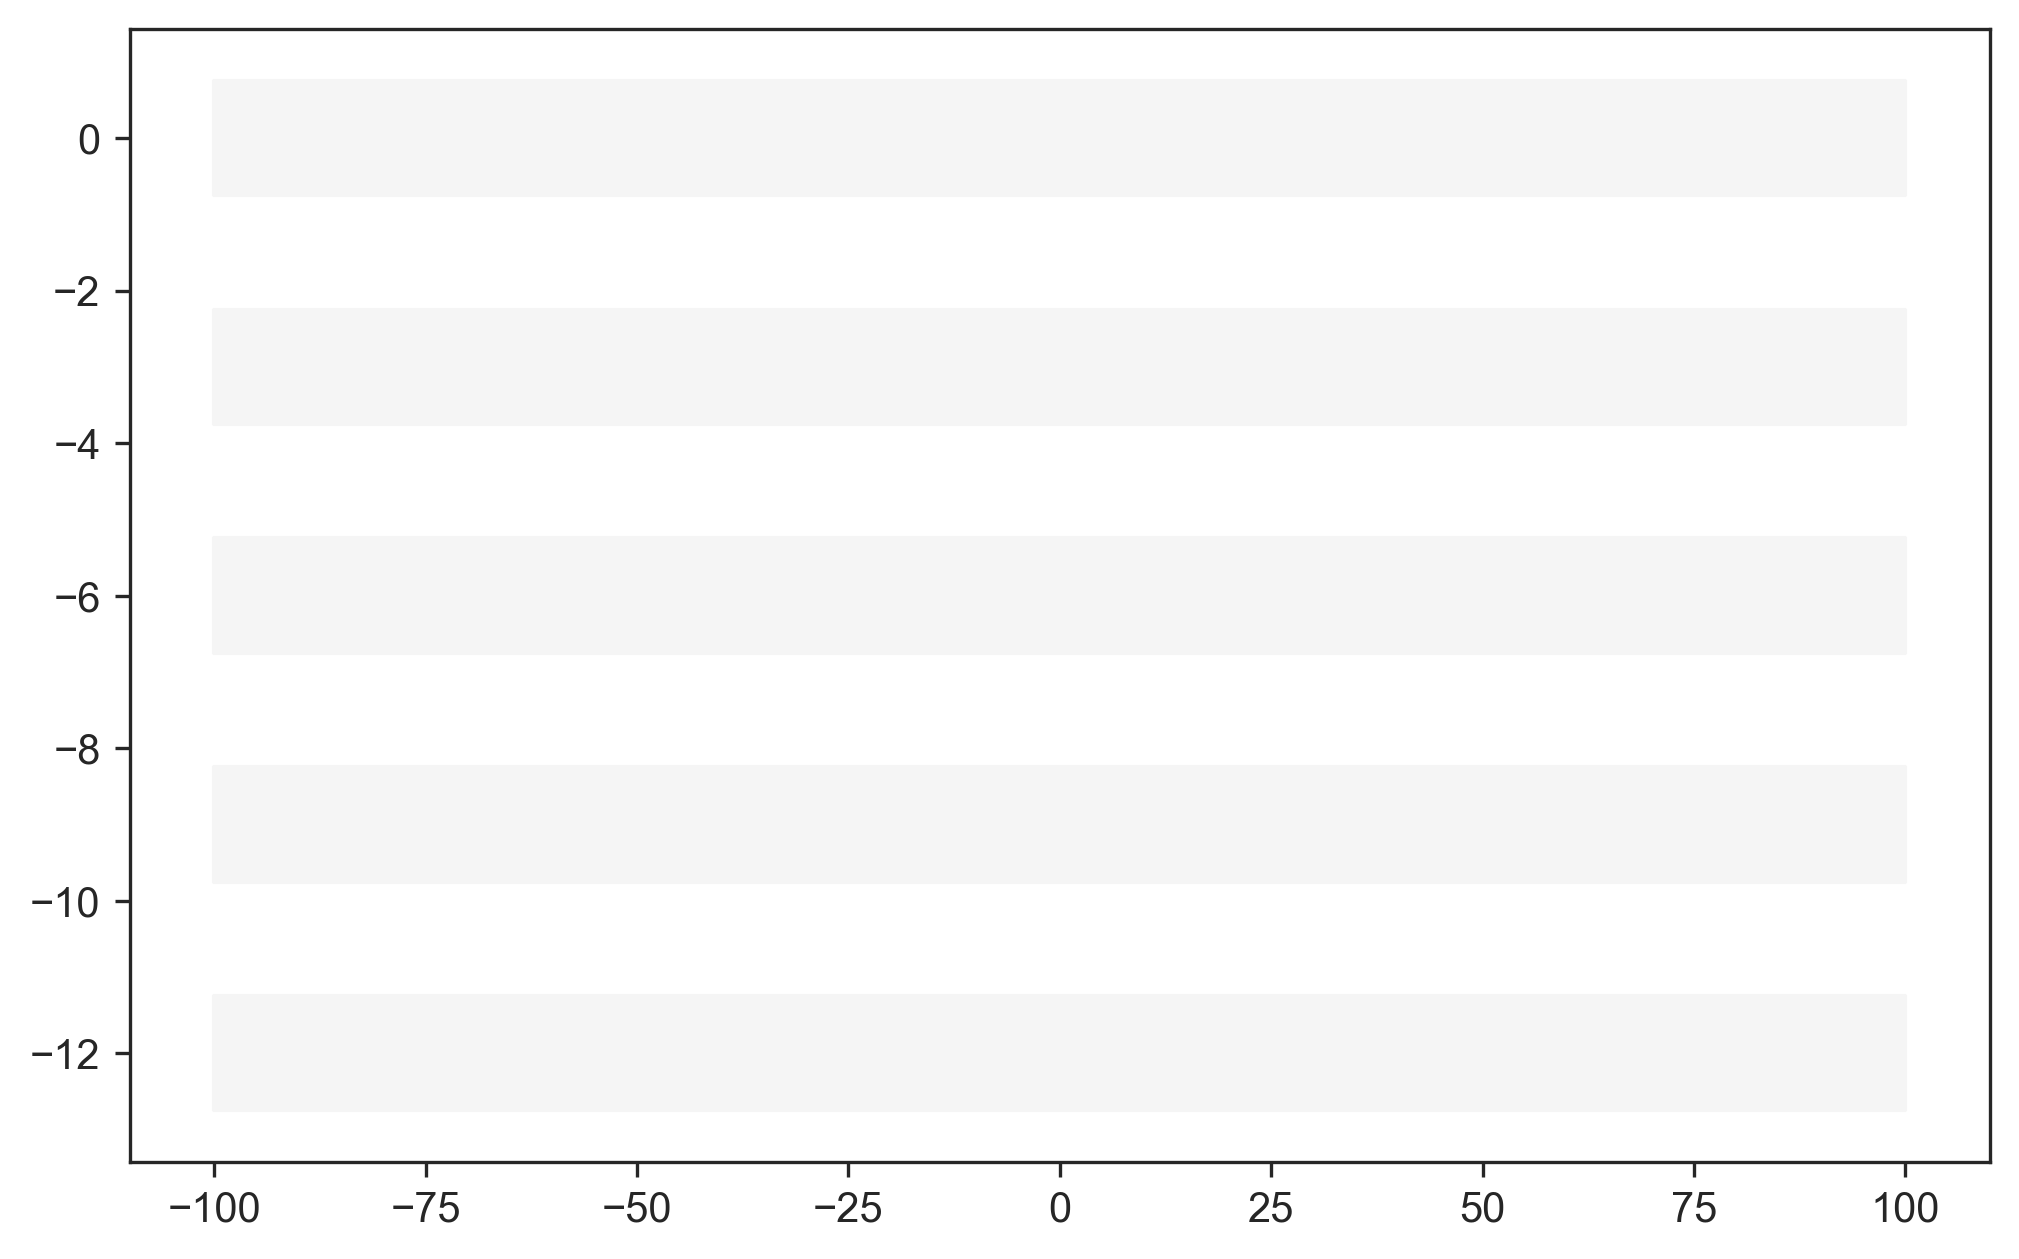

In [28]:
filenames = [f'out_final/cm_leavout_combined_{i}.txt' for i in range(len(cm_leavouts))]
print(cm_labels)
print(legend_labels)
import sensitivityplotlib as spl
spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels,
                               figsize=figsize,
                               legend_title=legend_title,
                               y_scale=y_scale,
                               y_offset=y_offset,
                               colors=colors,
                               leavouts=True,
                               bbox_to_anchor = bbox_to_anchor,
                               fontsize=fontsize)
plt.savefig('out_final/cm_leavout_combined_sensitivity.pdf')

##### plot active case model

['out/cm_leavout_trace_active_0.txt', 'out/cm_leavout_trace_active_1.txt', 'out/cm_leavout_trace_active_2.txt', 'out/cm_leavout_trace_active_3.txt', 'out/cm_leavout_trace_active_4.txt', 'out/cm_leavout_trace_active_5.txt', 'out/cm_leavout_trace_active_6.txt', 'out/cm_leavout_trace_active_7.txt', 'out/cm_leavout_trace_active_8.txt', 'out/cm_leavout_trace_active_9.txt', 'out/cm_leavout_trace_active_10.txt']
Mask Wearing
Symptomatic Testing
School Closure
Stay Home Order
None


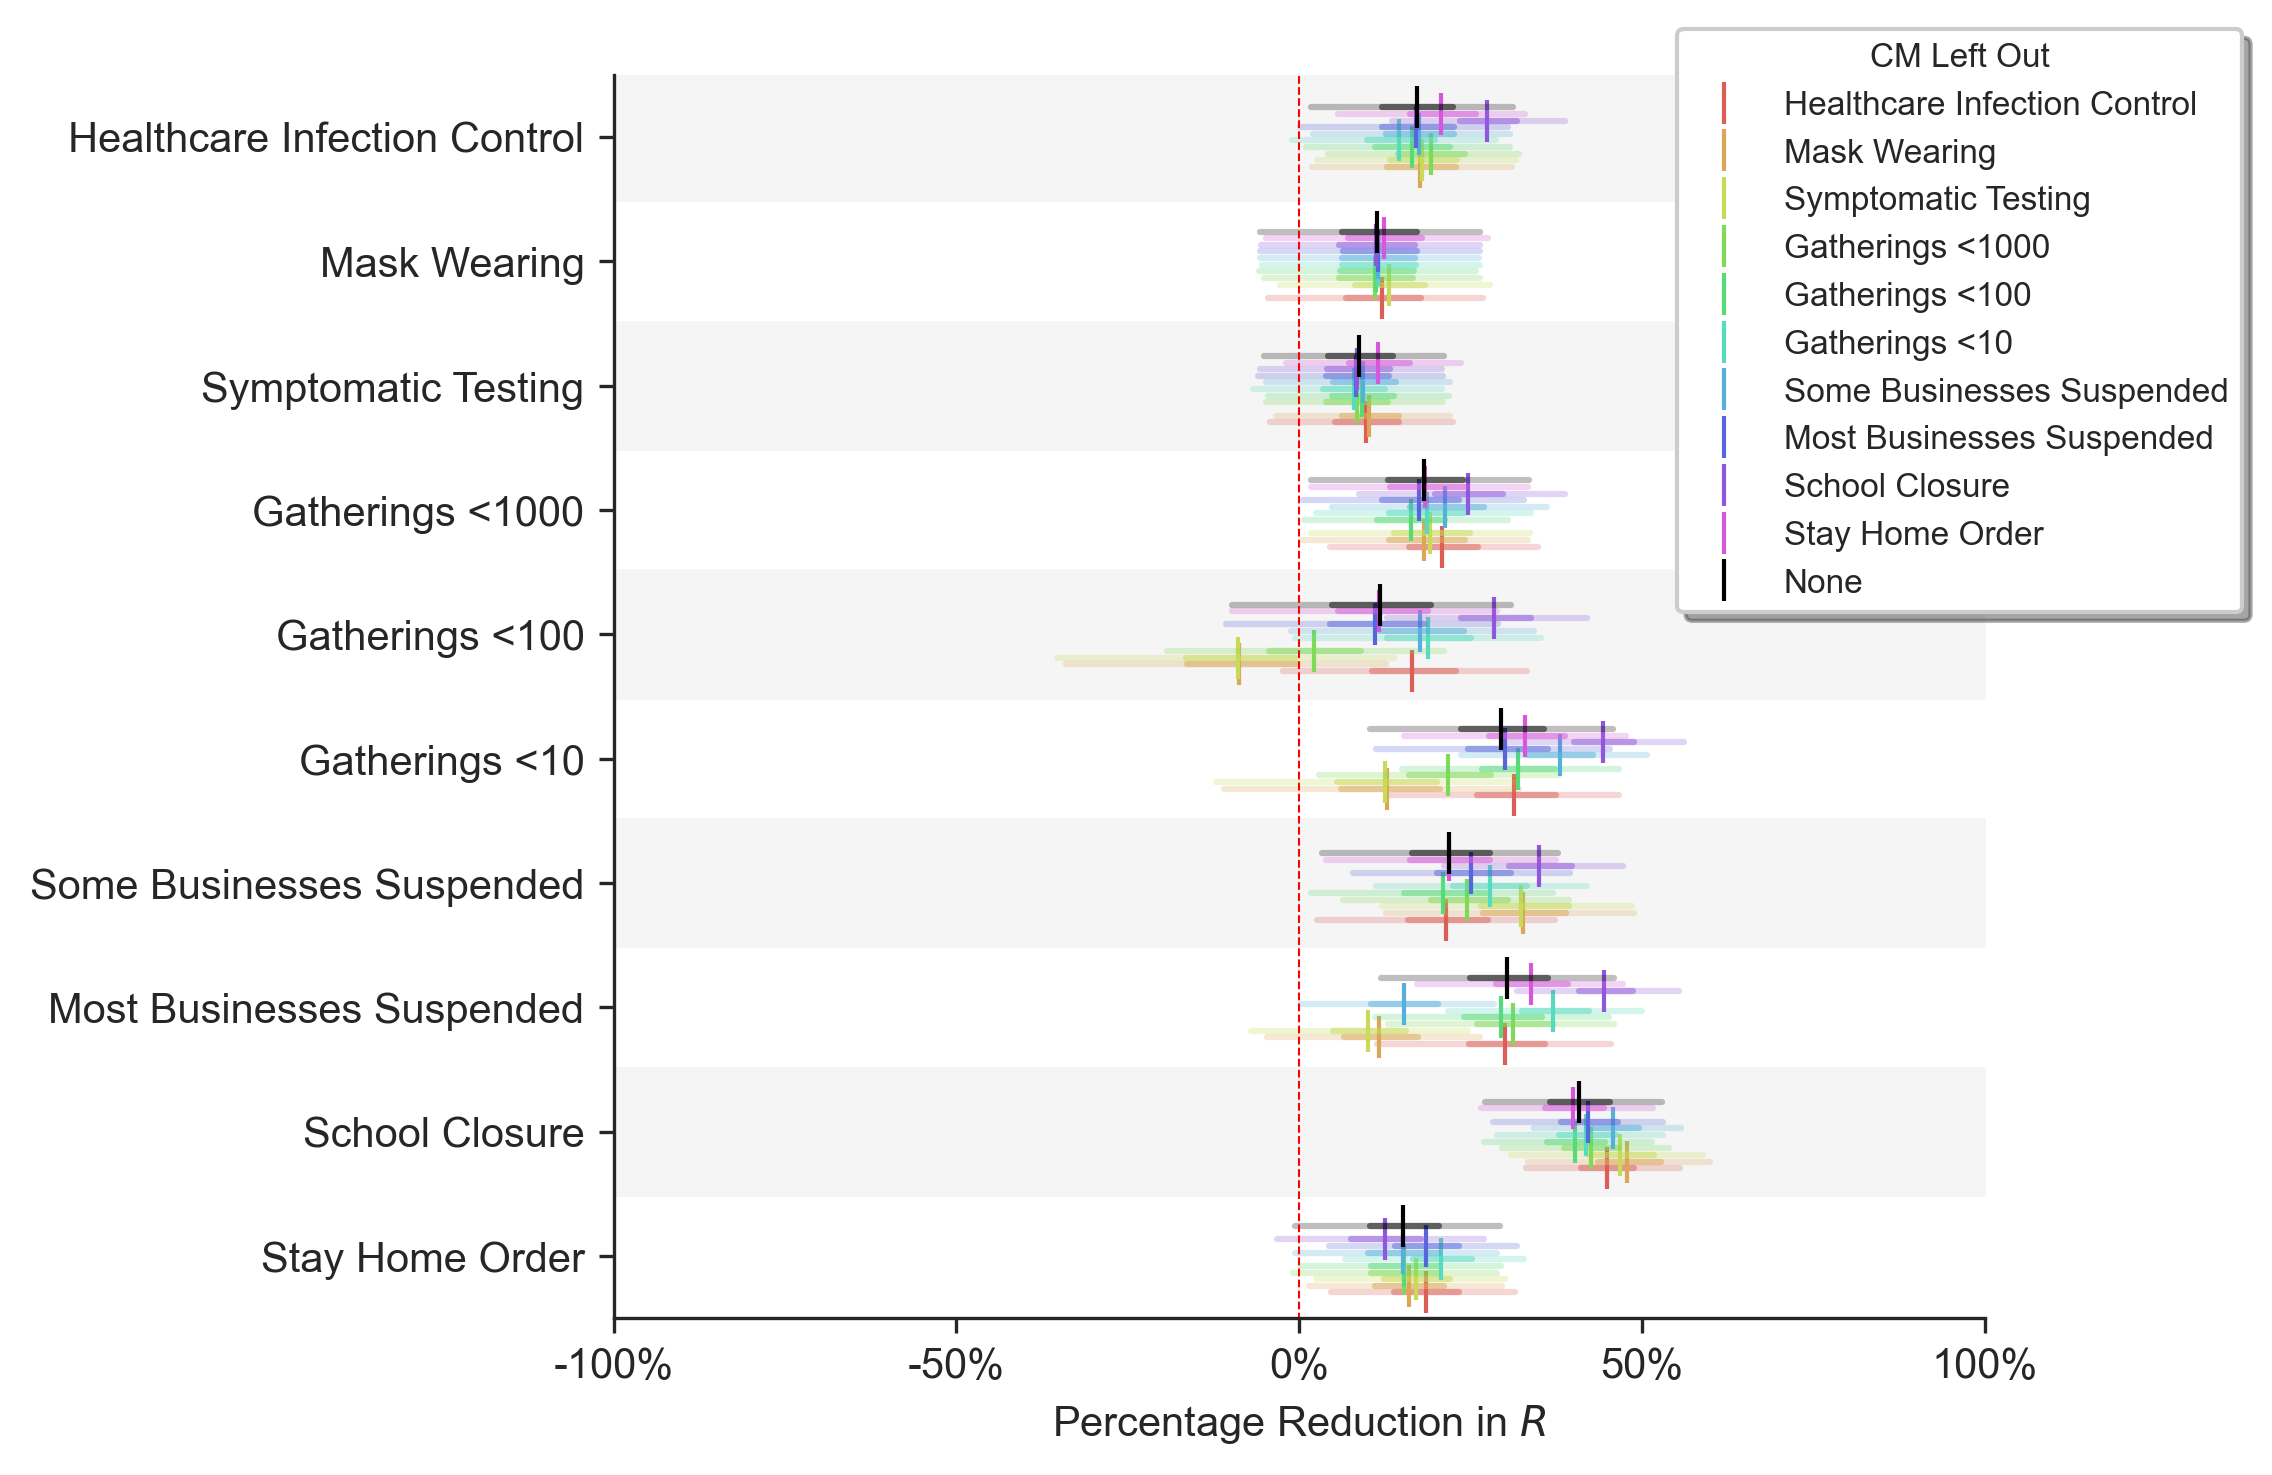

In [155]:
legend_labels = cm_leavouts
filenames = [f'out_final/cm_leavout_active_{i}.txt' for i in range(len(cm_leavouts))]
spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels,
                               figsize=figsize,
                               legend_title=legend_title,
                               y_scale=y_scale,
                               y_offset=y_offset,
                               colors=colors,
                               leavouts=True,
                               bbox_to_anchor = bbox_to_anchor,
                               fontsize=fontsize)
plt.savefig('out_final/cm_leavout_active_sensitivity.pdf')

##### plot deaths model

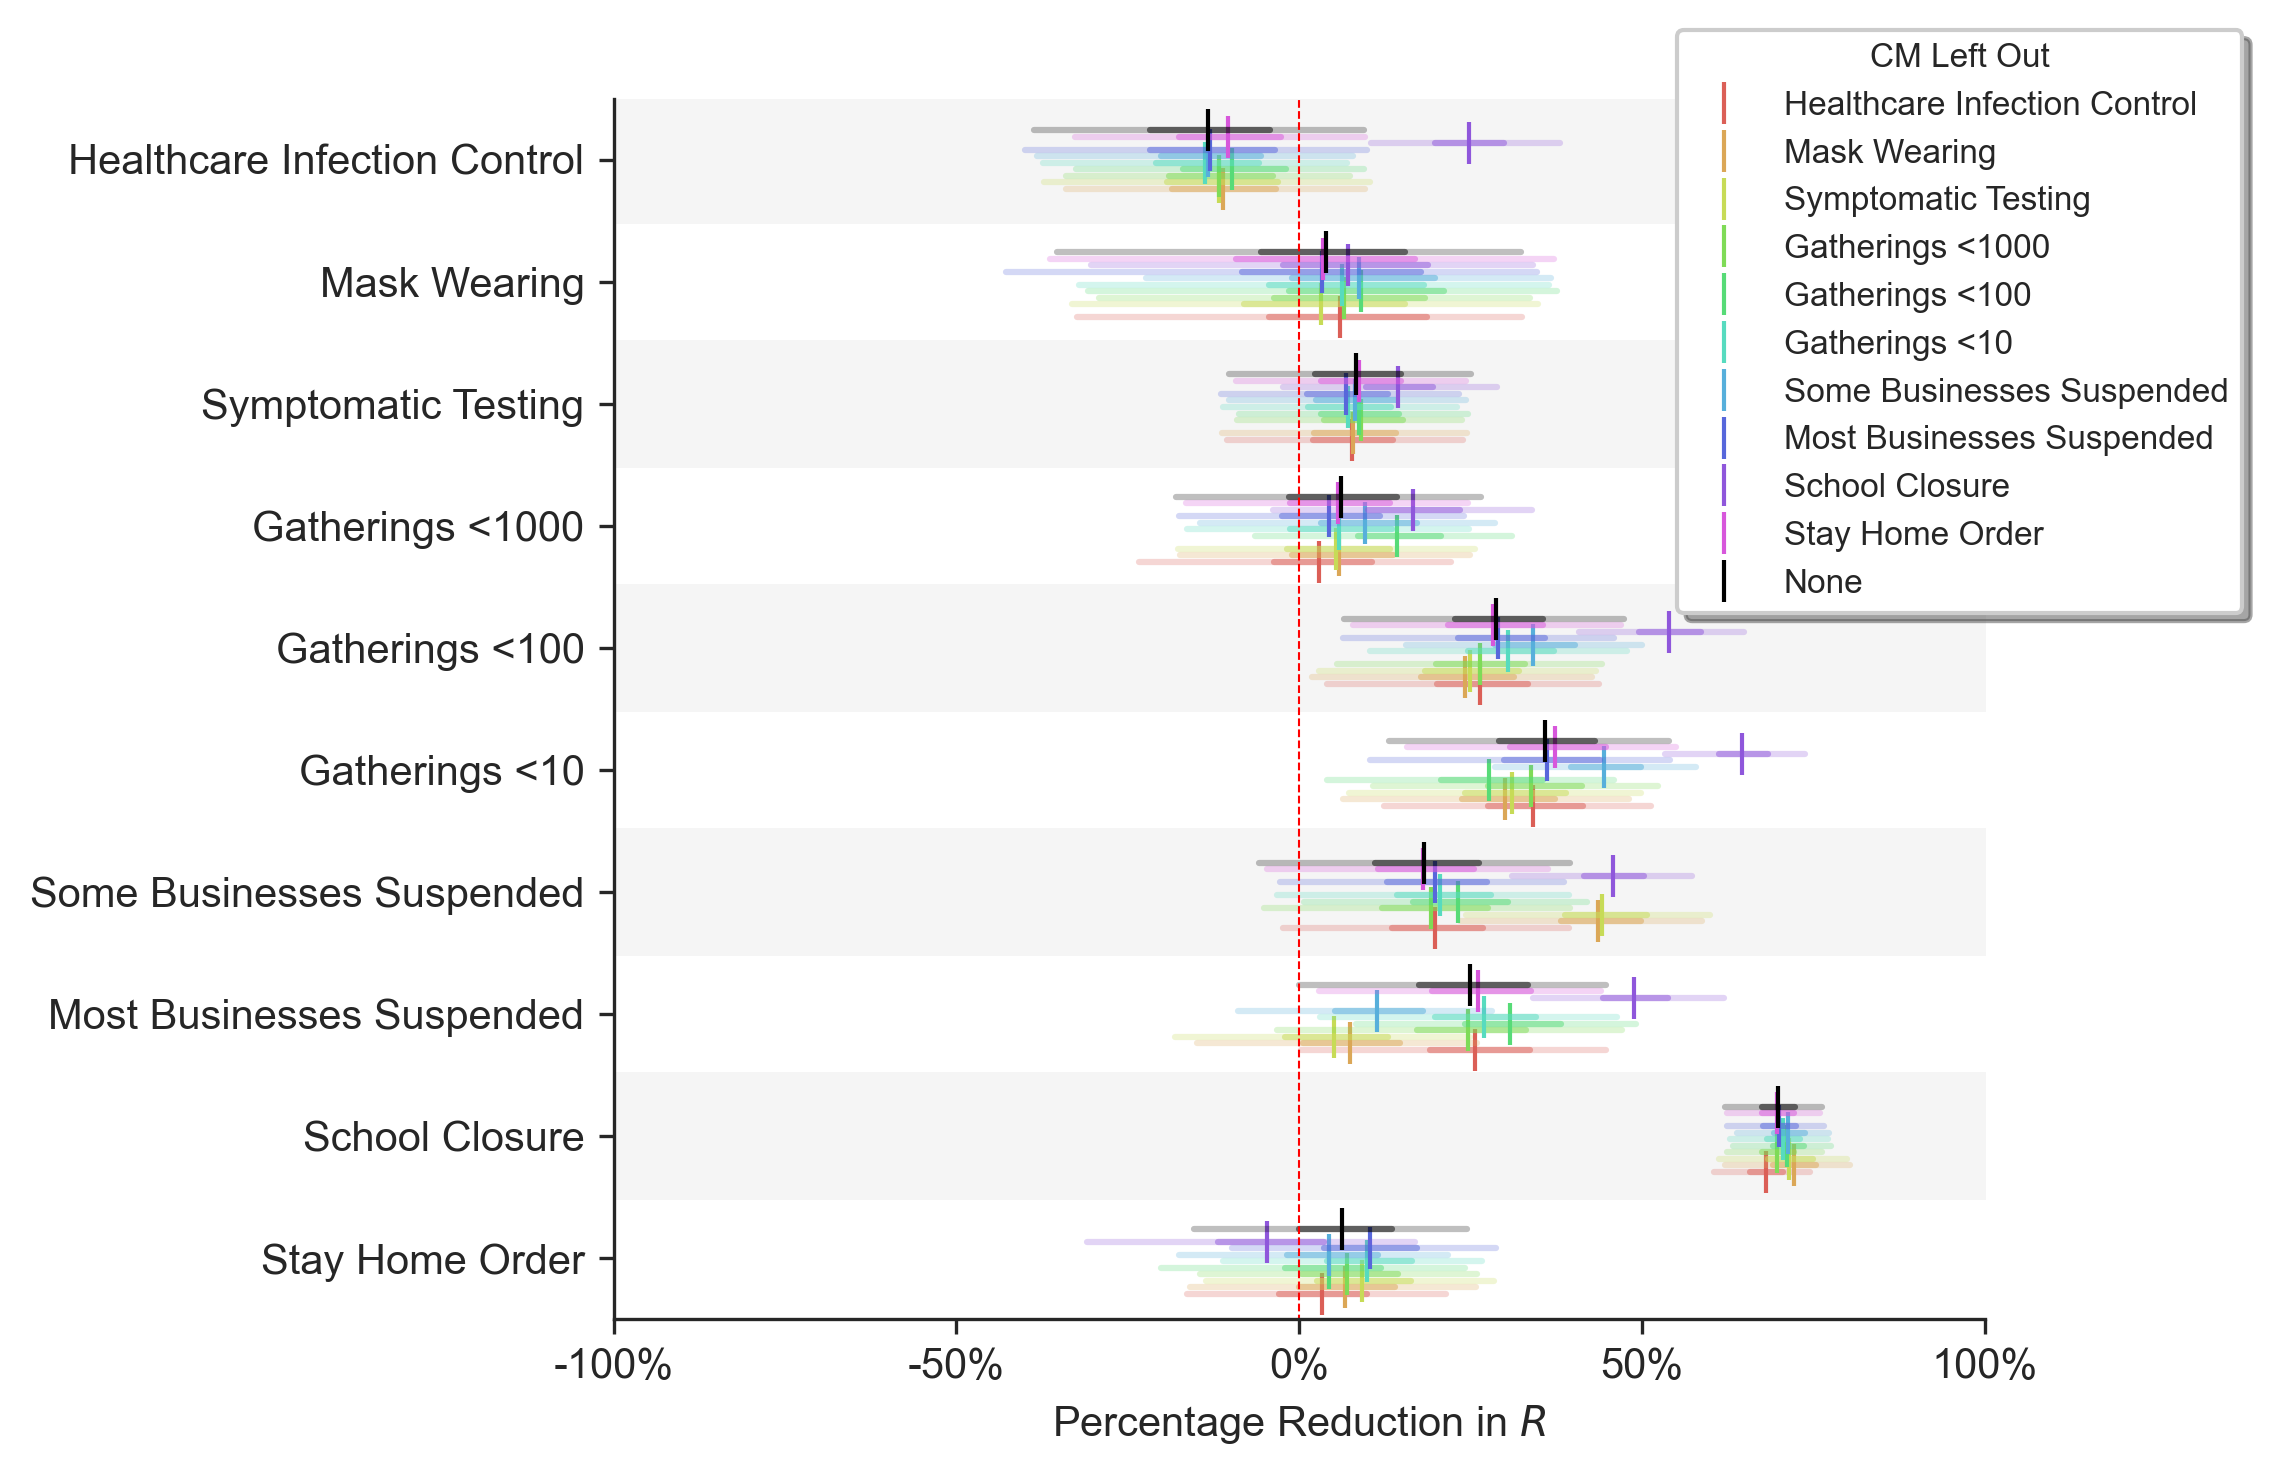

In [162]:
legend_labels = cm_leavouts
filenames = [f'out_final/cm_leavout_deaths_{i}.txt' for i in range(len(cm_leavouts))]

import sensitivityplotlib as spl
spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels, 
                               figsize=figsize,
                               legend_title=legend_title,
                               y_scale=y_scale,
                               y_offset=y_offset,
                               colors=colors,
                               leavouts=True,
                               bbox_to_anchor = bbox_to_anchor,
                               fontsize=fontsize)
plt.savefig('out_final/cm_leavout_deaths_sensitivity.pdf')